# Decision Tree

Estimated time needed: **15-30** minutes

## Objectives

After completing this lab you will be able to:

*   Develop a classification model using Decision Tree Algorithm


In this lab exercise, you will learn a popular machine learning algorithm, Decision Trees. You will use this classification algorithm to build a model from the historical data of patients, and their response to different medications. Then you will use the trained decision tree to predict the class of an unknown patient, or to find a proper drug for a new patient.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#about_dataset">About the dataset</a></li>
        <li><a href="https://#downloading_data">Downloading the Data</a></li>
        <li><a href="https://#pre-processing">Pre-processing</a></li>
        <li><a href="https://#setting_up_tree">Setting up the Decision Tree</a></li>
        <li><a href="https://#modeling">Modeling</a></li>
        <li><a href="https://#prediction">Prediction</a></li>
        <li><a href="https://#evaluation">Evaluation</a></li>
        <li><a href="https://#visualization">Visualization</a></li>
    </ol>
</div>
<br>
<hr>


Import the Following Libraries:

<ul>
    <li> <b>numpy (as np)</b> </li>
    <li> <b>pandas</b> </li>
    <li> <b>DecisionTreeClassifier</b> from <b>sklearn.tree</b> </li>
</ul>


In [1]:
pip install pyodide-py

  Using cached pyodide_py-0.27.3-py3-none-any.whl.metadata (1.8 kB)
Using cached pyodide_py-0.27.3-py3-none-any.whl (55 kB)
Note: you may need to restart the kernel to use updated packages.


if you uisng you own version comment out


In [5]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

In [2]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())

<div id="about_dataset">
    <h2>About the dataset</h2>
    Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y. 
    <br>
    <br>
    Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.
    <br>
    <br>
    It is a sample of multiclass classifier, and you can use the training part of the dataset 
    to build a decision tree, and then use it to predict the class of an unknown patient, or to prescribe a drug to a new patient.
</div>


<div id="downloading_data"> 
    <h2>Downloading the Data</h2>
    To download the data, we will use !wget to download it from IBM Object Storage.
</div>


In [3]:
import requests

url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
response = requests.get(url)
with open("drug200.csv", "wb") as file:
	file.write(response.content)
path = "drug200.csv"

Now, read the data using pandas dataframe:


In [6]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


<div id="practice"> 
    <h3>Practice</h3> 
    What is the size of data? 
</div>


In [7]:
# size of the dataset
my_data.shape



(200, 6)

<details><summary>Click here for the solution</summary>

```python
my_data.shape

```

</details>


<div href="pre-processing">
    <h2>Pre-processing</h2>
</div>


Using <b>my_data</b> as the Drug.csv data read by pandas, declare the following variables: <br>

<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of my_data) </li>
    <li> <b> y </b> as the <b> response vector </b> (target) </li>
</ul>


Remove the column containing the target name since it doesn't contain numeric values.


In [8]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]


array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.114],
       [28, 'F', 'NORMAL', 'HIGH', 7.798],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

As you may figure out, some features in this dataset are categorical, such as **Sex** or **BP**. Unfortunately, Sklearn Decision Trees does not handle categorical variables. We can still convert these features to numerical values using **pandas.get_dummies()**
to convert the categorical variable into dummy/indicator variables.


In [9]:
from sklearn import preprocessing
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.114],
       [28, 0, 2, 0, 7.798],
       [61, 0, 1, 0, 18.043]], dtype=object)

Now we can fill the target variable.


In [10]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

<hr>

<div id="setting_up_tree">
    <h2>Setting up the Decision Tree</h2>
    We will be using <b>train/test split</b> on our <b>decision tree</b>. Let's import <b>train_test_split</b> from <b>sklearn.cross_validation</b>.
</div>


In [11]:
from sklearn.model_selection import train_test_split

Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.


In [12]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

<h3>Practice</h3>
Print the shape of X_trainset and y_trainset. Ensure that the dimensions match.


In [13]:
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))



Shape of X training set (140, 5) &  Size of Y training set (140,)


<details><summary>Click here for the solution</summary>

```python
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))

```

</details>


Print the shape of X_testset and y_testset. Ensure that the dimensions match.


In [14]:
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))



Shape of X training set (60, 5) &  Size of Y training set (60,)


<details><summary>Click here for the solution</summary>

```python
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))

```

</details>


<hr>

<div id="modeling">
    <h2>Modeling</h2>
    We will first create an instance of the <b>DecisionTreeClassifier</b> called <b>drugTree</b>.<br>
    Inside of the classifier, specify <i> criterion="entropy" </i> so we can see the information gain of each node.
</div>


In [15]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Next, we will fit the data with the training feature matrix <b> X_trainset </b> and training  response vector <b> y_trainset </b>


In [16]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

<hr>

<div id="prediction">
    <h2>Prediction</h2>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.
</div>


In [17]:
predTree = drugTree.predict(X_testset)

You can print out <b>predTree</b> and <b>y_testset</b> if you want to visually compare the predictions to the actual values.


In [18]:
print (predTree [0:5])
print (y_testset [0:5])


['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


<hr>

<div id="evaluation">
    <h2>Evaluation</h2>
    Next, let's import <b>metrics</b> from sklearn and check the accuracy of our model.
</div>


In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.9833333333333333


**Accuracy classification score** computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


<hr>

<div id="visualization">
    <h2>Visualization</h2>

Let's visualize the tree

</div>


In [ ]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

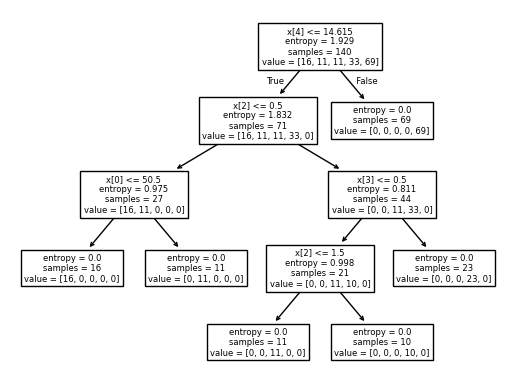

In [20]:
tree.plot_tree(drugTree)
plt.show()

### Thank you for completing this lab!